In [1]:
using Plots, Colors, DataFrames, CSV, GLM, Statistics
using BenchmarkTools, SparseArrays

cd("/Users/junwong/Dropbox/Second Year/Dingel - Trade/Assignments")

# Calibrating sector level data

In [2]:
df = DataFrame(CSV.File("data/bilateral_trade_country/bilateral_trade_sector_country.csv"));


In [3]:
# Total destination sector; collapse to country-origin/dest + sector-origin level
Xₙᵢʲ = combine(groupby(df, [:country_org, :country_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false);
rename!(Xₙᵢʲ, :trade_flow2014 => :X_ni_j0)

# Total spending by sector in country n 
total_spending_sectororg = combine(groupby(Xₙᵢʲ, [:country_dest, :sector_org]), :X_ni_j0 => sum, renamecols=false);
rename!(total_spending_sectororg, :X_ni_j0 => :spending_sectororg)

# πₙᵢʲ = Xₙᵢʲ / ∑ₒ Xₙₒʲ
Xₙᵢʲ = leftjoin(Xₙᵢʲ, total_spending_sectororg, on=[:country_dest, :sector_org])
transform!(Xₙᵢʲ, [:X_ni_j0, :spending_sectororg] => (./) => :pi_ni_j);

df = leftjoin(df, Xₙᵢʲ, on=[:country_org, :country_dest, :sector_org]);


Compute $\gamma$

In [4]:
# Total revenue of sector k in country n = ∑ᵢ Xᵢₙᵏ
revenue_by_sectororg = combine(groupby(Xₙᵢʲ, [:country_org, :sector_org]), :X_ni_j0 => sum, renamecols=false)
rename!(revenue_by_sectororg, [:country_org, :sector_org, :X_ni_j0] .=> [:country, :sector_dest, :revenue_sectororg])

# Purchases of sector k in country n on goods of sector j = ∑ᵢ Xₙᵢʲᵏ
cross_sector_spending = combine(groupby(df, [:country_dest, :sector_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false)
rename!(cross_sector_spending, [:country_dest, :trade_flow2014] .=> [:country, :spending_cross_sector])

# γₙʲᵏ = ∑ᵢ Xₙᵢʲᵏ / ∑ᵢ Xᵢₙᵏ
cross_sector_spending = innerjoin(cross_sector_spending, revenue_by_sectororg, on=[:country, :sector_dest])
transform!(cross_sector_spending, [:spending_cross_sector, :revenue_sectororg] => (./) => :gamma_n_jk)

# Impute γ with average of sector pairs (j,k) across countries 
nm_cross_sector = filter(:gamma_n_jk => x -> !(ismissing(x) || isnan(x)), cross_sector_spending)
nm_cross_sector = combine(groupby(nm_cross_sector, [:sector_org, :sector_dest]), :gamma_n_jk => mean)
cross_sector_spending = leftjoin(cross_sector_spending, nm_cross_sector, on=[:sector_org, :sector_dest])
for row in eachrow(cross_sector_spending)
    row[:gamma_n_jk] = ifelse(isnan(row[:gamma_n_jk]), row[:gamma_n_jk_mean], row[:gamma_n_jk])
end

# Find average γ across countries 
γ̄ʲᵏ = combine(groupby(cross_sector_spending, [:sector_dest, :sector_org]), :gamma_n_jk => mean);


Defining share value added in production

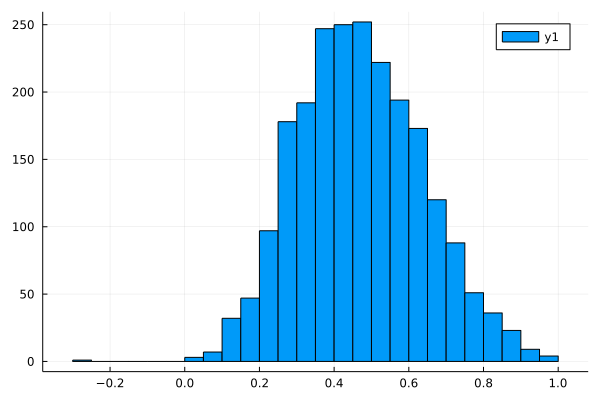

In [5]:
# ∑ⱼ γₙʲᵏ
gamma_sectdest = combine(groupby(cross_sector_spending, [:country, :sector_dest]), :gamma_n_jk => sum)

# γₙᵏ = 1 - ∑ⱼ γₙʲᵏ
gamma_sectdest[!, :gamma_n_k] = 1 .- gamma_sectdest[!,:gamma_n_jk_sum];

# Average value added 
avg_value_added_share = combine(groupby(gamma_sectdest, :sector_dest), :gamma_n_k => mean);

histogram(gamma_sectdest[!,:gamma_n_k])


Value added in initial equilibrium 

In [6]:
va⁰ = leftjoin(Xₙᵢʲ, gamma_sectdest, on=[:country_dest => :country, :sector_org => :sector_dest])
transform!(va⁰, [:gamma_n_k, :X_ni_j0] => (.*) => :value_added);
va⁰ = combine(groupby(va⁰, :country_dest), :value_added => sum, renamecols=false);


International transfers

In [7]:
# ∑ₒₖ Xₒₙᵏ
d1 = combine(groupby(df, :country_org), :trade_flow2014 => sum)
rename!(d1, :trade_flow2014_sum => :sum_x_on_k)

# ∑ₒₖ Xₙₒᵏ
d2 = combine(groupby(df, :country_dest), :trade_flow2014 => sum)
rename!(d2, :trade_flow2014_sum => :sum_x_no_k)

# h(w) Dₙ = ∑ₒₖ Xₙₒᵏ - ∑ₒₖ Xₒₙᵏ
transfers = innerjoin(d1, d2, on= :country_org => :country_dest)
transform!(transfers, [:sum_x_no_k, :sum_x_on_k] => (.-) => :transfer)

# Transfer as share of value added 
transfer_shares = innerjoin(transfers, va⁰, on= :country_org => :country_dest);



Final spending shares

In [8]:
# Rₙ⁰ = 0 since no tariff at baseline 

# ∑ᵢ Xₙᵢʲ is just total spending at destination across different origin sectors = total_spending_sectororg[!, :spending_sectororg]

# ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ: I think you should start with df
num = innerjoin(cross_sector_spending, Xₙᵢʲ, on=[:country => :country_org, :sector_dest => :sector_org])
transform!(num, [:X_ni_j0, :gamma_n_jk] => (.*) => :numerator)
num = combine(groupby(num, [:country, :sector_org]), :numerator => sum, renamecols = false)
select!(num, [:country, :sector_org, :numerator])

# αₙʲ = (∑ᵢ Xₙᵢʲ - ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ) / (Rₙ⁰ + wₙLₙ + h(w) Dₙ) 
num = innerjoin(num, transfer_shares, on=:country => :country_org)
num = innerjoin(num, total_spending_sectororg, on=[:country => :country_dest, :sector_org => :sector_org])
num.alpha_n_j = (num.spending_sectororg .- num.numerator) ./ (num.value_added .+ num.transfer);
#num.denom = num.value_added .+ num.sum_x_no_k .+ num.transfer;

# ᾱʲ 
avg_alpha = combine(groupby(num, [:sector_org]), :alpha_n_j => mean)
CSV.write("output/avg_alpha_j.csv", avg_alpha)

"output/avg_alpha_j.csv"

Calibrate $\theta^j$

In [9]:
theta_j = DataFrame(CSV.File("data/bilateral_trade_country/theta_caliendo_parro.csv"))
replace!(theta_j.theta_j, missing => mean(skipmissing(theta_j.theta_j))); # replace missing with average
θʲ = Array(theta_j[:,2]);


# Counterfactual Exercises

## Preview lets define things first

In [10]:
# Givens
gamma_i_kj = select(filter([:sector_dest, :sector_org] => (x, y) -> x <= size(θʲ, 1) && y <= size(θʲ, 1), cross_sector_spending), [:country, :sector_org, :sector_dest, :gamma_n_jk])
γᵢᵏʲ = zeros(42, size(θʲ, 1), size(θʲ, 1)) #country, sector_org, sector_dest
pi_ni_j = select(filter(:sector_org => x -> x <= size(θʲ, 1), Xₙᵢʲ), [:country_org, :country_dest, :sector_org, :pi_ni_j])
πₙᵢʲ = zeros(42, 42, size(θʲ, 1)) #country_org, country_dest, sector_org

for k in 1:size(θʲ, 1)
    γᵢᵏʲ[:, :, k] = Array(unstack(filter(:sector_dest => x -> x == k, gamma_i_kj), :country, :sector_org, :gamma_n_jk))[:, 2:end]
    πₙᵢʲ[:, :, k] = Array(unstack(filter(:sector_org => x -> x == k, pi_ni_j), :country_org, :country_dest, :pi_ni_j))[:, 2:end]
end

# country, sector_dest
γᵢʲ = Array(unstack(select(filter(:sector_dest => x -> x <= size(θʲ, 1), gamma_sectdest), [:country, :sector_dest, :gamma_n_jk_sum]), :country, :sector_dest, :gamma_n_jk_sum)[:, 2:end]);

λ̂ᵢʲ = ones(42, size(θʲ, 1))
#λ̂ᵢʲ[8, :] .= 1.1;

τ̂ = ones(42, 42)

αₙʲ = Array(unstack(num, :country, :sector_org, :alpha_n_j)[:,2:end]);

tfs = Array(transfers[!,:transfer]);



In [11]:
# to update
ŵ = ones(42, 1)
P̂ₙʲ = ones(42, size(θʲ, 1))


# First recover price index for all countries 
P_tilde_n_j = function (πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ)
    p_tilde_output = zeros(42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            inner = 0
            for country_org in 1:42 
                P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= (Pₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]) #i am flipping this because previously it was gamma_n^jk but now its gamma_i^kj
                end
                inner += πₙᵢ[country_org, country_dest, sector_org] * λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org])
            end
            p_tilde_output[country_dest, sector_org] = inner^(-1/θʲ[sector_org])
        end
    end
    
    return p_tilde_output
end


### here i think i am confused as to what is k and what is j??

# Iterate to find price index
iterate_p_tilde = function(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ, κ, tol)
    iter = 0
    P̂ = Pₙʲ 
    diff = Inf
    while maximum(diff) > tol
        iter +=1
        P̂_old = P̂
        P̂ = P_tilde_n_j(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂)
        diff = P̂ .- P̂_old
        P̂ = P̂ .+ κ .* diff
    end 
    
    return [P̂, iter]
end

p_b = iterate_p_tilde(πₙᵢʲ, λ̂ᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, 1, 1e-5);


In [12]:
# Given w and P find π̂
h(w) = w[end]
D̂ₙ = ones(42,1)

find_π_F = function(P̂ₙʲ, πₙᵢ, α, λᵢʲ, τ̂, ŵ, w⁰, γᵢʲ, tfs, D̂ₙ)
    π̂ₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
        for country_org in 1:42 
            P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= P̂ₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]
                end
                π̂ₙᵢʲ[country_org, country_dest, sector_org] = λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org]) * P̂ₙʲ[country_dest, sector_org]^(-θʲ[sector_org])
            end
        end
    end
    
    # work in progress
    Fₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            for country_org in 1:42 
                Fₙᵢʲ[country_org, country_dest, sector_org] = π̂ₙᵢʲ[country_org, country_dest, sector_org] * πₙᵢ[country_org, country_dest, sector_org] * α[country_dest, sector_org] * (w⁰[country_dest] * ŵ[country_dest] + tfs[country_dest] + h(w⁰[country_dest] * ŵ[country_dest]) / h(w⁰[country_dest]) * D̂ₙ[country_dest] )
            end
        end
    end
    
    return [π̂ₙᵢʲ, Fₙᵢʲ]
end



#17 (generic function with 1 method)

In [49]:
a = find_π_F(p_b[1], πₙᵢʲ, αₙʲ, λ̂ᵢʲ, τ̂, ŵ, Array(va⁰[!,:value_added]), γᵢʲ, tfs, D̂ₙ);

In [51]:
a[1]

42×42×22 Array{Float64, 3}:
[:, :, 1] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

Time to invert something?

In [14]:
τ¹ = zeros(42, 42, size(θʲ, 1));

In [15]:
test = function(dim, sector)
    index=DataFrame(iteration = Int[], country_dest = Int[], country_org = Int[], sector_org = Int[]) 
    iter = 0
    for country_dest in 1:dim
        for country_org in 1:dim
            for sector_org in 1:sector
                iter += 1 
                push!(index, (iter, country_dest, country_org, sector_org))
            end
        end
    end
    
    return index
end

@time rowindex = test(42, size(θʲ, 1));
@time colindex = test(42, size(θʲ, 1));


  0.147913 seconds (747.13 k allocations: 31.057 MiB, 89.63% compilation time)
  0.015498 seconds (383.06 k allocations: 9.849 MiB)


In [16]:
# It is best if you make two sparse matrices and then add them!!! 
d_eq_n = innerjoin(rowindex, colindex, on=[:country_dest], makeunique=true)
select!(d_eq_n, [:iteration, :iteration_1])
d_eq_n = Array(d_eq_n)

o_eq_n = innerjoin(rowindex, colindex, on=[:country_dest => :country_org], makeunique=true)
select!(o_eq_n, [:iteration, :iteration_1])
o_eq_n = Array(o_eq_n)

rowindex = Array(rowindex);
colindex = Array(colindex);


In [33]:
# Now let's focus on the values for d = n 
val = Real[]
new_rows = []
for row in eachrow(d_eq_n)
    i = row[1] #row (out of NNJ)
    j = row[2] #column (out of NNJ)
    num = πₙᵢʲ[rowindex[i,:][2], rowindex[i,:][3], rowindex[i,:][4]] * αₙʲ[rowindex[i,:][2], rowindex[i,:][4]] * τ¹[colindex[j,:][2], colindex[j,:][3], colindex[j,:][4]] / (1 + τ¹[colindex[i,:][2], colindex[j,:][3], colindex[j,:][4]])
    if num != 0 
        push!(val, num)
        push!(new_rows, row)
    end
end

if size(val, 1) != 0
    dn = sparse(new_rows[:,1], new_rows[:, 2], val);
else 
    dn = spzeros(size(rowindex, 1), size(colindex, 1));
end 

#dn = sparse(d_eq_n[:,1],d_eq_n[:,2],val)


38808×38808 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [40]:
# Now focus on values for o = n 
val = Real[] 
for row in eachrow(o_eq_n)
    i = row[1] #row (out of NNJ)
    j = row[2] #column (out of NNJ)
    num = πₙᵢʲ[rowindex[i,:][2], rowindex[i,:][3], rowindex[i,:][4]] * γᵢᵏʲ[rowindex[i,:][2], rowindex[i,:][4], colindex[j,:][4]] / (1 + τ¹[colindex[j,:][2], colindex[j,:][3], colindex[j,:][4]])
    if num != 0 
        push!(val, num)
    end
end

on = sparse(o_eq_n[:,1],o_eq_n[:,2],val);


38808×38808 SparseMatrixCSC{Real, Int64} with 35858592 stored entries:
⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⠀
⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⠀
⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡏⣿⣾⠀
⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⡀
⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⡇
⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡇
⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇
⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇
⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇
⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇
⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇
⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇
⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇
⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇
⢸⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿
⢸⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸
⠈⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸
⠀⡿⣿⣸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸
⠀⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸
⠀⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸

In [42]:
A = on + dn 

38808×38808 SparseMatrixCSC{Any, Int64} with 35858592 stored entries:
⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⠀
⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⠀
⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡏⣿⣾⠀
⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⡀
⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⡇
⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡇
⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇
⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇
⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇
⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇
⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇
⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇
⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇
⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇
⢸⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿
⢸⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸
⠈⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸
⠀⡿⣿⣸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸
⠀⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸
⠀⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸

In [55]:
# Now make a diagonal matrix 
val = Real[]
for i in 1:size(rowindex, 1)
        push!(val, a[1][rowindex[i,:][3], rowindex[i,:][2], rowindex[i,:][4]])
end

Π̂ = sparse(Array(1:size(rowindex, 1)),Array(1:size(rowindex, 1)),val);


In [56]:
Β = Π̂ * A

38808×38808 SparseMatrixCSC{Any, Int64} with 35858592 stored entries:
⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⠀
⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⠀
⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡏⣿⣾⠀
⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⡀
⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⡇
⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡇
⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇
⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇
⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇
⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇
⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇⡇⡇
⢸⢸⢸⢸⢸⣷⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇
⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇
⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⣸⢸⢸⢸⢸⢸⢸⣷⡇
⢸⢸⢸⢸⢸⢸⢸⢹⡇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⣼⢸⢸⢸⢸⢸⢸⢿
⢸⣼⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸⢿⡇⡇⡇⡇⡇⡇⡏⣿⢸⢸⢸⢸⢸⢸⢸
⠈⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢸⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸
⠀⡿⣿⣸⢸⢸⢸⢸⢸⢹⣧⡇⡇⡇⡇⡇⡇⡿⣿⢸⢸⢸⢸⢸⢸⢹⣇⡇⡇⡇⡇⡇⡇⣿⣼⢸⢸⢸⢸⢸
⠀⡇⡟⣿⢸⢸⢸⢸⢸⢸⢸⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⣇⡇⡇⡇⡇⡇⡇⣿⣾⢸⢸⢸⢸
⠀⡇⡇⣿⣾⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸⢸⢸⢸⢻⡇⡇⡇⡇⡇⡇⡇⣿⢸⢸⢸⢸

In [ ]:
# NOTE BE SURE TO CHECK ORG DEST IN THESE CALCULCATIONS 
xx = zeros(size(rowindez, 1), 1)
f = a[2]
for v in 1:10 
    xx = xx + f
    f = Β * f
end


In [60]:
a[2]

42×42×22 Array{Float64, 3}:
[:, :, 1] =
 13587.3            0.15555      36.0465     …    44.8629         23.4045
     0.902066    1780.47          1.97947          0.172239        3.3162
     0.272393      10.3873     1347.07             1.79162         4.88299
     0.492991       3.74212      10.1092           0.146738        5.9557
    10.997          1.71891     111.228          270.995         365.148
     7.9981         0.799312     44.5141     …    16.4691       1267.18
     0.3227         0.962062      0.273014         0.0286837       0.547599
    19.6689         1.79724      18.4806          70.6336        113.314
     0.117992      42.9056        1.74335          0.0553986       0.839251
     3.29666      178.217       113.601            7.21095        42.2996
     7.16037        4.20041       9.76091    …     2.95833         9.15607
     1.59598       38.1572       54.323            1.33883        18.8896
     0.0248317      0.0118007     0.428039         0.00412701      0.1